Python code for Course Project of Research Module - data cleaning and descriptive statistic

Author: Xinyue Wang

## 1.2 Graduation Rate

In this part, we calculated the school level achieved rate for the national senior certificate (NSC), as the measurement of educational outcome.


In [1]:
# set environment

import pandas as pd
import numpy as np
import re


In [2]:
# read SNAP and NSC data

nsc2010 = pd.read_csv('nsc/zaf-nsce-2010-centre-overall-v1.0.csv', encoding='ISO-8859-1')
nsc2011 = pd.read_csv('nsc/zaf-nsce-2011-centre-overall-v1.0.csv', encoding='ISO-8859-1')
masterlist = pd.read_csv('nsc/snaps-1997-2013-masterlist-v1.csv', encoding='ISO-8859-1')
geoinfo = pd.read_csv('nsc/district.csv', encoding='ISO-8859-1')
poverty_score = pd.read_csv('nids/poverty_score.csv')

# drop SNAP and NSC irrelevant variables columns

masterlist = masterlist[['natemis','datayear','schoolname','phase_doe','eidistrict','quintile','sector']]
nsc2010 = nsc2010[['date','emisno','gender','province','regionname','districtname','achieved']]
nsc2011 = nsc2011[['date','emisno','gender','province','regionname','districtname','quintile','achieved']]

# drop SNAP and NSC irrelevant observations rows

masterlist = masterlist[ (masterlist.sector=='1') & ((masterlist.phase_doe=='4') | (masterlist.phase_doe=='5')) ]
nsc2010 = nsc2010[ (nsc2010.achieved.notna()) & (nsc2010.emisno!=0) ]
nsc2011 = nsc2011[ (nsc2011.achieved.notna()) & (nsc2011.emisno!=0) ]


In [3]:
# calculate NSC school achieved rate

def achieved_rate(nscyear):

    # average school passrate for genders
    passrate = nscyear.groupby('emisno')['achieved'].mean()
    nscyear['achieved'][nscyear.duplicated('emisno')] = passrate

    # keep unique passrate for each emis school
    nscyear = nscyear.drop_duplicates('emisno')
    nscyear = nscyear.drop(columns = ['gender'])
    
    return nscyear

nsc2010 = achieved_rate(nsc2010)
nsc2011 = achieved_rate(nsc2011)


In [4]:
# add quintile to NSC2010 from NSC2011
nsc2010 = nsc2010.merge(nsc2011[['emisno','quintile']], on=['emisno'], how='left')


# add quintile to NSC from SNAP

# emis in NSC 2010-2016
nscemis = pd.concat([nsc2010.emisno,nsc2011.emisno], ignore_index=True).unique()

def quintile_info(nscyear):

    # keep SNAP data with relevant NSC emis
    snapdata = masterlist[masterlist.natemis.isin(nscemis)]

    # keep unique(smallest) quintile for each emis in SNAP
    snapdata = snapdata.sort_values('quintile').drop_duplicates('natemis')

    # merge SNAP and NSC quintile
    snapdata = snapdata.rename(columns={'natemis':'emisno', 'quintile':'quintile_snap'})
    nsc_with_q = pd.merge(nscyear, snapdata[['emisno','quintile_snap','eidistrict']], on=['emisno'], how='left')

    # replace NSC invalid quintile from SNAP
    nsc_with_q.quintile = np.where(nsc_with_q.quintile.isin([1,2,3,4,5]), nsc_with_q.quintile, nsc_with_q.quintile_snap)
    nsc_with_q = nsc_with_q.drop(['quintile_snap'], axis=1)

    # set NSC invalid quintile to NaN, then drop
    nsc_with_q.quintile = np.where(nsc_with_q.quintile.isin([1,2,3,4,5]), nsc_with_q.quintile, np.nan)
    nsc_with_q = nsc_with_q[nsc_with_q.quintile.notna()]

    # change NSC column names
    year = re.findall( "\d{4}", nsc_with_q.iloc[1]['date'].astype(str) )
    nsc_with_q = nsc_with_q.rename(columns={'achieved':('achieved_' + year[0]), 'quintile':('quintile_' + year[0])})
    nsc_with_q = nsc_with_q.drop(['date'], axis=1)

    return nsc_with_q

nsc2010 = quintile_info(nsc2010)
nsc2011 = quintile_info(nsc2011)

print('NSC data observations:', nsc2010.shape[0], nsc2011.shape[0])


NSC data observations: 5509 5523


In [5]:
# add district to NSC2010 NSC2011

def district_info(nscyear):

    # select non-string value in NSC districtname
    nonstr = nscyear.districtname.str.findall(r'\d+').explode().unique()

    # replace NSC non-string districtname from SNAP
    nscyear.districtname = np.where(nscyear.districtname.isin(nonstr), nscyear.eidistrict, nscyear.districtname)
    
    # set NSC invalid districtname to 99
    nscyear.districtname.replace(np.nan, 99, inplace=True)

    # add code by mapping NSC district name
    df_district = nscyear[nscyear.districtname.isin(geoinfo.districtname)]
    merge_district = df_district.merge(geoinfo[['districtname','code','provincecode']], on=['districtname'], how='left')

    # add code by mapping NSC region name
    df_region = nscyear.drop(df_district.index)
    merge_region = df_region.merge(geoinfo[['regionname','code','provincecode']], on=['regionname'], how='left')
    merge_region.drop_duplicates('emisno', inplace=True)

    # combine to creat final NSC data
    nsc_with_district = pd.concat([merge_district, merge_region], ignore_index=True)
    nsc_with_district = nsc_with_district.drop(['regionname','districtname','eidistrict','province'], axis=1)

    return nsc_with_district

nsc2010 = district_info(nsc2010)
nsc2011 = district_info(nsc2011)


In [6]:
# combine NSC into one dataframe

# in nsc dataframe, values in 'school_quintile'(quintile 2010) and 'quintile_y'(quintile 2011) are identical.

nsc = pd.merge(nsc2010, nsc2011, on=['emisno','code','provincecode'], how='inner')
nsc.rename(columns={'quintile_2010':'school_quintile', 'code':'district_code'}, inplace=True)


## 1.3 Combined final dataset and Figures

In this part, we calculated the combined poverty scores by combining the district poverty score with the school survey quintile.

We also draw some plots to show our data's descriptive features. 

In [7]:
from matplotlib import pyplot as plt
from matplotlib import cm

In [8]:
# creat final dataframe

combined_data = nsc[['emisno','district_code','provincecode','school_quintile','achieved_2010','achieved_2011']].merge(poverty_score, on='district_code')
combined_data['combined_pov_score'] = combined_data['district_poverty_score'] * 3/4 + combined_data['school_quintile'] * 1/5 * 1/4

combined_data.to_csv('combined_data.csv')

Descriptive figures:

<function matplotlib.pyplot.show(close=None, block=None)>

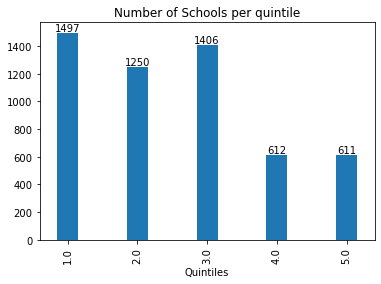

In [9]:
# number of schools per quintile

ax = nsc.groupby('school_quintile').size().plot.bar(width=0.3)
ax.bar_label(ax.containers[0])
plt.xlabel('Quintiles')
plt.title('Number of Schools per quintile')
plt.show

([<matplotlib.axis.XTick at 0x19247f80a60>,
 [Text(0, 0, 'Western Cape'),
  Text(2, 0, 'Northern Cape'),
  Text(1, 0, 'Eastern Cape'),
  Text(3, 0, 'Free State'),
  Text(4, 0, 'KwaZulu-Natal'),
  Text(7, 0, 'Mpumalanga'),
  Text(8, 0, 'Limpopo'),
  Text(5, 0, 'North West'),
  Text(6, 0, 'Gauteng')])

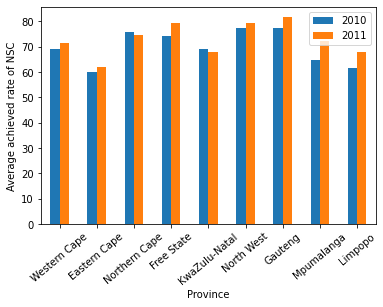

In [10]:
# average achieved rate per province

combined_data.groupby('provincecode').mean().plot(y=['achieved_2010','achieved_2011'], kind='bar', label=['2010','2011'])
plt.xlabel('Province')
plt.ylabel('Average achieved rate of NSC')
plt.xticks((geoinfo.provincecode.unique()-1), geoinfo.province.unique(), rotation=40)


Text(0.5, 1.0, 'Average achieved rate per quintile')

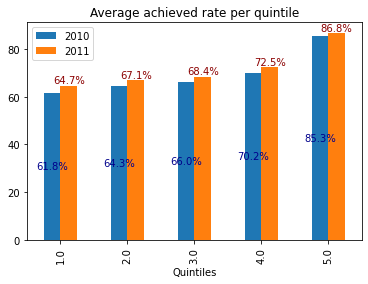

In [11]:
# average achieved rate per quintile 

ax = combined_data.groupby('school_quintile').mean().plot(y=['achieved_2010','achieved_2011'], kind='bar', label=['2010','2011'])
ax.bar_label(ax.containers[0], fmt='%.1f%%', label_type='center', color='darkblue')
ax.bar_label(ax.containers[1], fmt='%.1f%%', label_type='edge', color='darkred')

plt.xlabel('Quintiles')
plt.title('Average achieved rate per quintile')

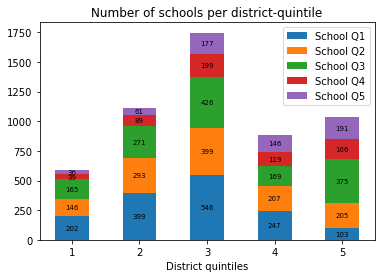

In [12]:
# number of schools per district quintile 

a = combined_data.groupby(['district_quintile', 'school_quintile'], as_index=False).size()
x_bottom = [0,0,0,0,0]

fig, ax = plt.subplots()

for i in range(1,6):
    x_axis = a[a.school_quintile==i]['size']
    ax.bar(a.district_quintile.unique(), x_axis, bottom=x_bottom, width=0.5, label='School Q{}'.format(i))
    x_bottom = x_bottom + np.array(x_axis)
    ax.bar_label(ax.containers[i-1], fontsize=7, label_type='center')

plt.xlabel('District quintiles')
plt.title('Number of schools per district-quintile')

plt.legend()
plt.show()


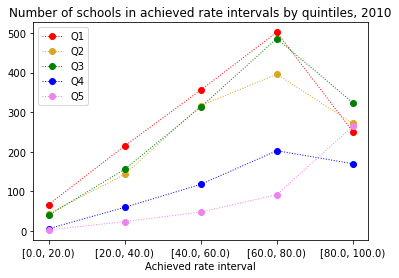

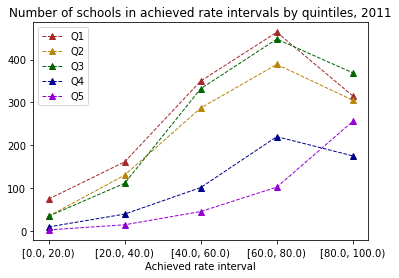

In [13]:
# number of schools in achieved rate interval per quintile 

ach_interval = np.quantile(a = np.linspace(0,100), q = [0, .2, .4, .6, .8, 1])

num_2010 = combined_data.groupby( ['school_quintile', pd.cut(combined_data.achieved_2010, bins=ach_interval, right=False)], as_index=False).size()
num_2011 = combined_data.groupby( ['school_quintile', pd.cut(combined_data.achieved_2011, bins=ach_interval, right=False)], as_index=False).size()

# plot for 2010
for i in range(1,6):  
    df2010 = num_2010[num_2010.school_quintile == i]
    colors1 = ['red', 'goldenrod', 'green', 'blue', 'violet']
    plt.plot(df2010['achieved_2010'].astype(str), df2010['size'], marker='o', linestyle=':', linewidth=1, color=colors1[i-1], label='Q{}'.format(i))

plt.xlabel('Achieved rate interval')
plt.title('Number of schools in achieved rate intervals by quintiles, 2010')
plt.legend()
plt.show()

# plot for 2011
for i in range(1,6):
    df2011 = num_2011[num_2011.school_quintile == i]
    colors2 = ['brown', 'darkgoldenrod', 'darkgreen', 'darkblue', 'darkviolet']
    plt.plot(df2011['achieved_2011'].astype(str), df2011['size'], marker='^', linestyle='--', linewidth=1, color=colors2[i-1], label='Q{}'.format(i))

plt.xlabel('Achieved rate interval')
plt.title('Number of schools in achieved rate intervals by quintiles, 2011')
plt.legend()
plt.show()
